In [168]:
import pandas as pd
import matplotlib.pylab as plt
import scipy.stats  as stats

In [174]:
# Windows only
survey_result_df = pd.read_csv(r'D:\UCBerkeley\CourseWork\201909\W266\GitHub\FinalProject-Collab\post-model-check\survey_results.csv', sep='\t') 
# survey_result_df = pd.read_csv('survey_results.csv', sep='\t') 
survey_result_df.apply(pd.to_numeric, errors='coerce')

sim_index_nodup_lst = sorted(set(survey_result_df['Sim_index']))
print(len(sim_index_nodup_lst))

83


In [175]:
sim_index_nodup_lst_check = sim_index_nodup_lst.copy()

survey_prep_questions_path = r'D:\UCBerkeley\CourseWork\201909\W266\GitHub\FinalProject-Collab\survey\question_prep1.txt'
# survey_prep_questions_path = '../survey/question_prep1.txt'
survey_prep_questions_file = open(survey_prep_questions_path, 'r', encoding="utf8").read().split('\n')
sim_input_sentence_lst = []
for (i, row) in enumerate(survey_prep_questions_file):
    # The first row is column names
    if i > 0 and len(row.split('<entry>')) > 1:
        match_index = int(row.split('<entry>')[0])
        if match_index in sim_index_nodup_lst_check:
            # Sanity check: below should print 0 if everything works correctly
            # print(sim_index_nodup_lst_check.index(match_index))
            del sim_index_nodup_lst_check[sim_index_nodup_lst_check.index(match_index)]
            sim_input_sentence_lst.append(row.split('<entry>')[1])
        
print(len(sim_input_sentence_lst))
print(sim_index_nodup_lst_check)

# When I made the survey, I accidentally copied the question from an earlier copy of survey/question_prep1.txt
# As a result, the question with index 201 was in the survey but not in the latest copy of survey/question_prep1.txt
# Manually fix this situation below

82
[201]


In [176]:
sim_input_sentence_lst.insert(sim_index_nodup_lst.index(201), 'But its full realization also implies a greater and greater perfection in the instrumentalities for pacific settlement of controversies between nations.')
print(len(sim_input_sentence_lst))


83


In [177]:
# Windows only
gpt2_tuned_path = r'D:\UCBerkeley\CourseWork\201909\W266\GitHub\FinalProject-Collab\3.CalculateMetrics\20191201_run\test_gpt2tuned_metrics.txt'
xlnet_path = r'D:\UCBerkeley\CourseWork\201909\W266\GitHub\FinalProject-Collab\3.CalculateMetrics\20191201_run\test_xlnet-base-cased_metrics.txt'
lstm_attention_path = r'D:\UCBerkeley\CourseWork\201909\W266\GitHub\FinalProject-Collab\3.CalculateMetrics\20191201_run\test_lstm-attention_metrics.txt'
gpt2_untuned_bert_path = r'D:\UCBerkeley\CourseWork\201909\W266\GitHub\FinalProject-Collab\3.CalculateMetrics\20191201_run\test_bert_smash_metrics.txt'
gpt2_untuned_path = r'D:\UCBerkeley\CourseWork\201909\W266\GitHub\FinalProject-Collab\3.CalculateMetrics\20191201_run\test_gpt2_metrics.txt'

# gpt2_tuned_path = '../3.CalculateMetrics/20191129_run/test_gpt2tuned_metrics.txt'
# xlnet_path = '../3.CalculateMetrics/20191129_run/test_xlnet-base-cased_metrics.txt'
# lstm_attention_path = '../3.CalculateMetrics/20191129_run/test_lstm-attention_metrics.txt'
# gpt2_untuned_bert_path = '../3.CalculateMetrics/20191129_run/test_bert_smash_metrics.txt'
# gpt2_untuned_path = '../3.CalculateMetrics/20191129_run/test_gpt2_metrics.txt'

In [178]:
gpt2_tuned_file = open(gpt2_tuned_path, 'r', encoding="utf8").read().split('<new_line>')
xlnet_file = open(xlnet_path, 'r', encoding="utf8").read().split('<new_line>')
lstm_attention_file = open(lstm_attention_path, 'r', encoding="utf8").read().split('<new_line>')
gpt2_untuned_bert_file = open(gpt2_untuned_bert_path, 'r', encoding="utf8").read().split('<new_line>')
gpt2_untuned_file = open(gpt2_untuned_path, 'r', encoding="utf8").read().split('<new_line>')

In [179]:
survey_result_df.columns


Index(['Sim_index', 'Actual', 'gpt2_tuned', 'xlnet', 'lstm_attention',
       'gpt2_untuned_bert', 'gpt2_untuned'],
      dtype='object')

In [180]:
def sim_metrics_extraction (file, sim_input_sentence_local):
    bleu_res_lst = []
    rouge_n_lst = []
    rouge_l_lst = []
    bert_p_lst = []
    bert_r_lst = []
    bert_f1_lst = []
    
    sim_input_sentence_lst_check = sim_input_sentence_local.copy()
    for i, row in enumerate(file):
        # inp, actual, pred, bleu_res, rouge_n, rouge_l, BERT_P, BERT_R, BERT_F1
        # The file starts with <new_line>
        if i > 0:
            inp = row.split('<entry>')[0]
            bleu_res = row.split('<entry>')[3]
            rouge_n = row.split('<entry>')[4]
            rouge_l = row.split('<entry>')[5]
            BERT_P = row.split('<entry>')[6]
            BERT_R = row.split('<entry>')[7]
            BERT_F1 = row.split('<entry>')[8]
    
            if inp in sim_input_sentence_lst_check:
                # Sanity check: below should print 0 if everything works correctly
                # print(sim_input_sentence_lst_check.index(inp))
                del sim_input_sentence_lst_check[sim_input_sentence_lst_check.index(inp)]
                bleu_res_lst.append(float(bleu_res))
                rouge_n_lst.append(float(rouge_n))
                rouge_l_lst.append(float(rouge_l))
                bert_p_lst.append(float(BERT_P))
                bert_r_lst.append(float(BERT_R))
                bert_f1_lst.append(float(BERT_F1))
        # 2700 is max_line_review set in check-generated-against-test.ipynb
        if i == 2700 or len(sim_input_sentence_lst_check) == 0:
            break
    
    if len(sim_input_sentence_lst_check) > 0:
        print('Warning: missing input sentences - ', sim_input_sentence_lst_check)
        
    df = pd.DataFrame(list(zip( 
        sim_index_nodup_lst, 
        bleu_res_lst, 
        rouge_n_lst, 
        rouge_l_lst, 
        bert_p_lst, 
        bert_r_lst,
        bert_f1_lst
        )), 
        columns =['Sim_index', 'bleu_res', 'rouge_n', 'rouge_l', 'bert_p', 'bert_r', 'bert_f1']) 
        
    return df

In [181]:
metrics_df_dict = dict()
merge_df_dict = dict()
# loop through all five methods
for i in range(2,7):
    method_of_interest = survey_result_df.columns[i]
    file_of_interest = vars()[method_of_interest+'_file'] 
    metrics_df_dict[i] = sim_metrics_extraction(file_of_interest, sim_input_sentence_lst)
    # The code below achieves the same purpose as above but less preferred
    # Reference: https://stackoverflow.com/questions/2259224/python-inserting-a-variable-value-into-a-variable-name
    # vars()['metrics_df'+str(i)] = sim_metrics_extraction(file_of_interest, sim_input_sentence_lst)
    survey_result_df_method = survey_result_df.copy()
    survey_result_df_method.rename(columns={method_of_interest:"human_eval"}, inplace=True)
    survey_result_df_method = survey_result_df_method[['Sim_index', 'human_eval']]
    
    merge_df_dict[i] = pd.merge(survey_result_df_method, metrics_df_dict[i], on='Sim_index')
    # The code below achieves the same purpose as above but less preferred
    # vars()['merge_df'+str(i)] = pd.merge(survey_result_df_method, vars()['metrics_df'+str(i)], on='Sim_index')

In [182]:
merge_df_all = merge_df_dict[2].append([merge_df_dict[3], merge_df_dict[4], merge_df_dict[5], merge_df_dict[6]])

In [183]:
merge_df_all
merge_df_all.to_csv(r'D:\UCBerkeley\CourseWork\201909\W266\GitHub\FinalProject-Collab\post-model-check\merge_human_eval_with_metrics.csv', sep='\t', index=False)


In [184]:
avg_by_human_eval_df = merge_df_all.groupby(['human_eval']).mean()
print(avg_by_human_eval_df)


              Sim_index  bleu_res   rouge_n   rouge_l    bert_p    bert_r  \
human_eval                                                                  
1.0         1438.722846  0.081034  0.813313  0.386793  0.855066  0.853796   
2.0         1298.507092  0.087757  0.799164  0.392936  0.854475  0.862530   
3.0         1381.975610  0.087583  0.792685  0.383276  0.848230  0.863066   
4.0         1342.902222  0.082156  0.793935  0.363723  0.847582  0.866778   
5.0         1234.491228  0.086290  0.794667  0.373388  0.854789  0.869405   

             bert_f1  
human_eval            
1.0         0.854186  
2.0         0.858266  
3.0         0.855358  
4.0         0.856833  
5.0         0.861754  


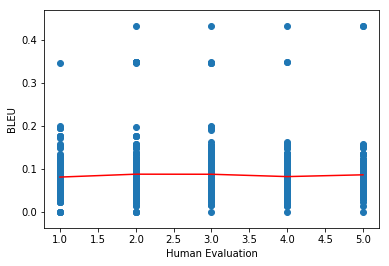

In [185]:
# 'bleu_res', 'rouge_n', 'rouge_l', 'bert_p', 'bert_r', 'bert_f1'
plt.scatter(merge_df_all['human_eval'], merge_df_all['bleu_res'])
plt.plot(avg_by_human_eval_df.index, avg_by_human_eval_df['bleu_res'], '-r')
plt.xlabel('Human Evaluation')
plt.ylabel('BLEU')
plt.show()

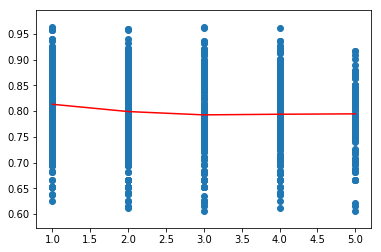

In [186]:
plt.scatter(merge_df_all['human_eval'], merge_df_all['rouge_n'])
plt.plot(avg_by_human_eval_df.index, avg_by_human_eval_df['rouge_n'], '-r')
plt.show()

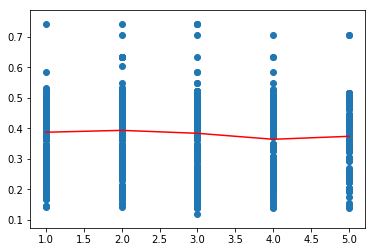

In [187]:
plt.scatter(merge_df_all['human_eval'], merge_df_all['rouge_l'])
plt.plot(avg_by_human_eval_df.index, avg_by_human_eval_df['rouge_l'], '-r')
plt.show()

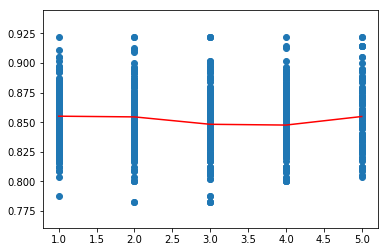

In [188]:
plt.scatter(merge_df_all['human_eval'], merge_df_all['bert_p'])
plt.plot(avg_by_human_eval_df.index, avg_by_human_eval_df['bert_p'], '-r')
plt.show()

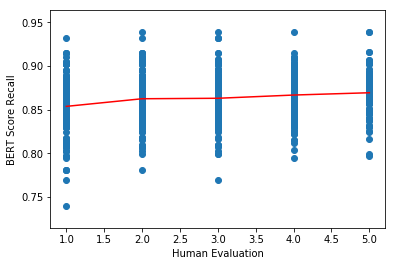

In [189]:
plt.scatter(merge_df_all['human_eval'], merge_df_all['bert_r'])
plt.plot(avg_by_human_eval_df.index, avg_by_human_eval_df['bert_r'], '-r')
plt.xlabel('Human Evaluation')
plt.ylabel('BERT Score Recall')
plt.show()

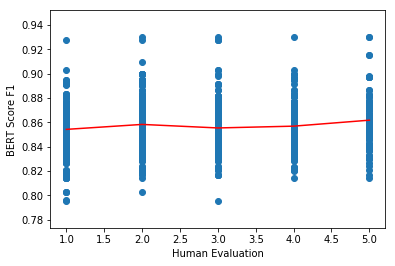

In [190]:
plt.scatter(merge_df_all['human_eval'], merge_df_all['bert_f1'])
plt.plot(avg_by_human_eval_df.index, avg_by_human_eval_df['bert_f1'], '-r')
plt.xlabel('Human Evaluation')
plt.ylabel('BERT Score F1')
plt.show()

In [191]:
print(merge_df_all.drop(columns=['Sim_index']).corr())
print(stats.pearsonr(merge_df_all['human_eval'], merge_df_all['bleu_res']))
print(stats.pearsonr(merge_df_all['human_eval'], merge_df_all['rouge_n']))
print(stats.pearsonr(merge_df_all['human_eval'], merge_df_all['rouge_l']))
print(stats.pearsonr(merge_df_all['human_eval'], merge_df_all['bert_p']))
print(stats.pearsonr(merge_df_all['human_eval'], merge_df_all['bert_r']))
print(stats.pearsonr(merge_df_all['human_eval'], merge_df_all['bert_f1']))




            human_eval  bleu_res   rouge_n   rouge_l    bert_p    bert_r  \
human_eval    1.000000  0.012778 -0.084271 -0.070441 -0.077534  0.194405   
bleu_res      0.012778  1.000000  0.131870  0.285317  0.223574  0.271269   
rouge_n      -0.084271  0.131870  1.000000  0.312424  0.061247 -0.021213   
rouge_l      -0.070441  0.285317  0.312424  1.000000  0.298826  0.112913   
bert_p       -0.077534  0.223574  0.061247  0.298826  1.000000  0.254125   
bert_r        0.194405  0.271269 -0.021213  0.112913  0.254125  1.000000   
bert_f1       0.072690  0.312370  0.029047  0.269873  0.792510  0.790935   

             bert_f1  
human_eval  0.072690  
bleu_res    0.312370  
rouge_n     0.029047  
rouge_l     0.269873  
bert_p      0.792510  
bert_r      0.790935  
bert_f1     1.000000  
(0.012778295317910872, 0.6616983450295317)
(-0.0842706580342381, 0.003843588553339502)
(-0.07044058620884339, 0.015734691708830136)
(-0.07753390793327812, 0.007839552440325259)
(0.19440466616103658, 1.805008